In [15]:
import finesse
from finesse.components import Space, Lens, Laser, Nothing

import matplotlib.pyplot as plt

You can use this jupyter notebook alongside documentation found online for Finesse3 regarding its [Python API](https://finesse.ifosim.org/docs/latest/usage/python_api/index.html)

# The Beam Through a Set of Lenses

First I am going to set up a Model, which Finesse uses to remember properties of `Components` (such as the ones I've imported above), as well as the distances of `Spaces`. 
Below is a function which you can call to set up this model.
It goes over what setting up a model [should look like](https://finesse.ifosim.org/docs/latest/usage/python_api/models_and_components.html)

In [48]:
def setup_model(f1, f2, d1, d2, d3, visualise=False):
    """
    Creates a simple model of two lenses of focal lengths f1,f2 and three distances, d1, d2, d3.
    """
    M = finesse.model.Model()
    M.lambda0 = 775e-9 # set the model's wavelength to 775nm
    
    # first create a laser
    Laser_775 = Laser("laser_775", P=1, f=(300e6)/(775e-9))
    M.add(Laser_775)
    
    # create two lenses
    
    lens_1 = Lens("lens_1", f=f1)
    lens_2 = Lens("lens_2", f=f2)
    
    M.add([lens_1, lens_2])
    
    # add a target, represented by a 'Nothing' node
    target = Nothing("target")
    M.add(target)
    
    # now create the spaces between components
    s_L_l1 = Space("s_L_l1", portA=Laser_775.p1, portB=lens_1.p1, L=d1)
    s_l1_l2 = Space("s_l1_l2", portA=lens_1.p2, portB=lens_2.p1, L=d2)
    s_l2_t = Space("s_l2_t", portA=lens_2.p2, portB=target.p1, L=d3)
    
    M.add([s_L_l1, s_l1_l2, s_l2_t])
    
    # check if the output looks alright
    # NB The graph just shows what is connected to what. It doesn't represent physical space.
    if visualise == True:
        print(M.component_tree())
        M.plot_graph(arrows=True, graphviz=False, layout="spiral")
    return M

Let's create starting beam-parameters that would represent your collimators downstairs.
You have two collimators, [F80APC-850](https://www.thorlabs.com/thorProduct.cfm?partNumber=F280APC-A) and [TC12APC-532](https://www.thorlabs.com/thorproduct.cfm?partnumber=TC12APC-532).
The $\omega_0$ and $z$ are found from their spec sheets from these pages.

In [49]:
q_f80apc_850 = finesse.gaussian.BeamParam(wavelength=775e-9, w0=3.3e-3, z=-17.4e-3)
q_tc12apc_532 = finesse.gaussian.BeamParam(wavelength=775e-9, w0=2.2e-3, z=-8.39e-3)
print(q_f80apc_850)
print(q_tc12apc_532)

BeamParam(w0=3.3 mm, z=-17.4 mm, w=3.3 mm, Rc=-112 km)
BeamParam(w0=2.2 mm, z=-8.39 mm, w=2.2 mm, Rc=-45.88 km)


Now it's a case of creating simulations with the model.
Let's look at how the beam develops with these two starting parameters when $d_1=4$, $d_2=0.6$, $d_3=0.9$ and $f_1=0.2$, $f_2=1.5$.
You may refer to the [documentation](https://finesse.ifosim.org/docs/latest/usage/homs/propagating_beams.html) to see how else this can be done.

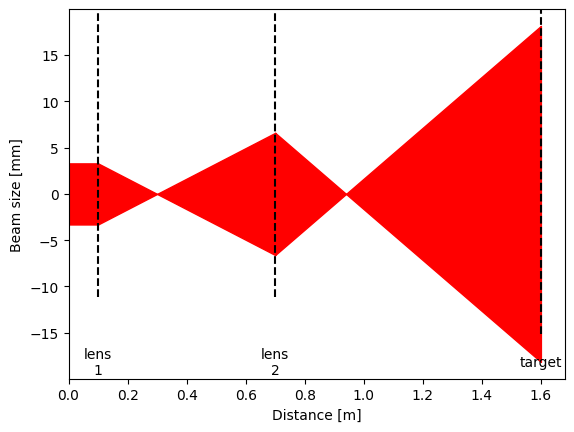

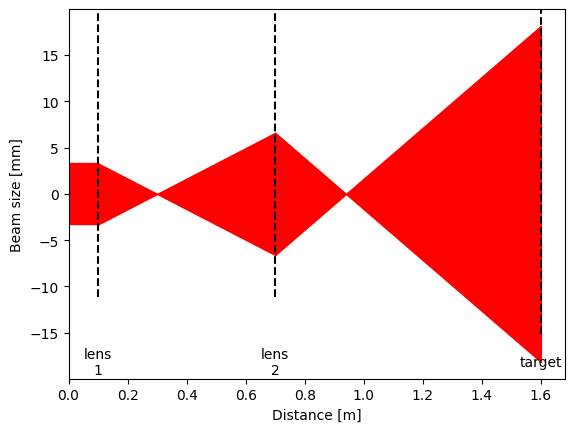

In [50]:
# set up the model with parameters described above
M = setup_model(0.2, 0.15, 0.1, 0.6, 0.9)

# create a beam path for the simulation to follow from the first node to the last node in the model, M
nodes = M.optical_nodes
beam_path = M.path(nodes[1], nodes[-1])

# simulate
sim_f80 = M.propagate_beam(path=beam_path, q_in=q_f80apc_850)
sim_tc12 = M.propagate_beam(path=beam_path, q_in=q_f80apc_850)

# plot graphs
sim_f80.plot("beamsize", resolution="all",single_sided=False)
sim_tc12.plot("beamsize", single_sided=False)
plt.show()

As shown in the documentation, we can also investigate properties of the beam parameter at each point.

In [39]:
print("f80apc_850:".upper())
print(sim_f80)
print("tc12apc_532:".upper())
print(sim_tc12)

F80APC_850:
┌────────────────╥───────┬───────────┬───────────┬───────────┬────────────┬───────────┬───────────┬─────────────────┐
│                ║   z   │    w0     │    zr     │     w     │    RoC     │     S     │ Acc. Gouy │        q        │
╞════════════════╬═══════╪═══════════╪═══════════╪═══════════╪════════════╪═══════════╪═══════════╪═════════════════╡
│ laser_775.p1.o ║   0 m │    3.3 mm │  44.144 m │    3.3 mm │     112 km │ 8.9289 uD │        0° │ 0.017 + 44.144j │
├────────────────╫───────┼───────────┼───────────┼───────────┼────────────┼───────────┼───────────┼─────────────────┤
│  lens_1.p1.i   ║   4 m │    3.3 mm │  44.144 m │ 3.3136 mm │   489.09 m │ 2.0446 mD │   5.1773° │ 4.017 + 44.144j │
├────────────────╫───────┼───────────┼───────────┼───────────┼────────────┼───────────┼───────────┼─────────────────┤
│  lens_1.p2.o   ║   4 m │ 14.895 um │ 899.39 um │ 3.3136 mm │ -200.08 mm │  -4.998 D │   5.1773° │ -0.200 + 0.001j │
├────────────────╫───────┼───────────┼──────

# Your Task

I hope this serves as a good example of what is possible using the `finesse` package.
You should be able to call the `setup_model` function inside this notebook whenever you want.
Use it as a template to create more complicated or simplistic Models, which you can use to simulate things.

* Using the knife-edge technique, measure the beam-waist, $\omega$, at a sensible distance, $x$, from the collimator.
* Given the beam-waist of the collimators you have, with *pen and paper* calculate the $\omega$ after $x$ distance on your optical bench.
* Simulate the beam fired from a collimator into free-space for $x$ distance on your optical bench.

Remember, if you find my code for the beam-profile a pain to work with, you can *always manually measure the waist using the knife-edge yourself*.
This is somewhat time consuming but good in a pinch.
You can still come up with your own analysis using the data from the power meter yourself though.

Compare your theoretical, simulated and experimental results.

Next, a more complicated task.
This is the crux.
You're going to do something similar, but this time you will use lenses to fire the beam onto a target, which will represent your crystal.
Recall that there exists an optimal ratio between the rayleigh range (or confocal parameter) and the length of the crystal to acheive the best SHG efficiency.

* Given $L=20$mm, calculate the optimal rayleigh length that you will need for SHG.
* Given the focal length of your lenses, what configuration of lenses ($l_1$ before or after $l_2$?) and distances, $d_1, d_2, d_3$, do you need to acheive this rayleigh length at the second lens' focus?

Use simulations to help find your answer.
Remember, you are constrained by the area you have to work inside your optical table.
Bonus points if you constrain yourself to the area inside your enclosure!
In fact: You will save yourself a lot of time for your future self if you do, as you will need to do this at some point anyway!

Once you have found the distances you need, recreate the setup on your optical bench.
Remember to use pinholes to ensure a good straight line through the pair of lenses.
Finally, confirm the beam waist at where you think the crystal should be positioned.
You may find it easier to characterise the beam using the knife-edge method instead.
